## imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join

import cv2
import pickle
import datetime
import time
import random

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import multiprocessing as mp

## helper

In [2]:
# pre-cond: train_data is a np array
# post-cond: train_data is saved via pickle
def save(X, y, name):
    pickle_out = open("X."+name+".pkl","wb")
    pickle.dump(X, pickle_out)
    pickle_out.close()
    
    pickle_out = open("y."+name+".pkl","wb")
    pickle.dump(y, pickle_out)
    pickle_out.close()
    print("saved: ", name)

# constants

In [ ]:
IMG_SIZE = 227
NUM_CLASSES = 5
noodle_classes = ['pad_thai','pho','ramen','spaghetti_bolognese','spaghetti_carbonara']

# create_data function

In [3]:
# this function pre-processes every food image
# and assigns label to the respective food class
# shoves everything into an array called data_set
# then separates the data_set array into features array and label array
def create_data(root, _name):
    data_set = []

    # pre-process: re-size and re-color
    for noodle_class in noodle_classes:
        path = os.path.join(root, noodle_class)
        label = noodle_classes.index(noodle_class) # FIX LATER: use enumerate
        print(noodle_class,label)
        #input('wait1')

        for img in os.listdir(path): # pad_thai/1432432.jpg, pad_thai/12314.jpg . . .
                if img.startswith('.'): # .DS_Store
                    continue
                # each image is a 2D array of RGB value
                try:
                    img_arr = cv2.imread(os.path.join(path,img))
                    img_to_rgb = img_arr[:,:,::-1] 
                    new_img = cv2.resize(img_to_rgb,(IMG_SIZE,IMG_SIZE)) 
                    data_set.append([new_img,label]) # shove (X,y) in here cause we wanna shuffle 
                except Exception as e:
                    print("create exception: ",e)
        
    # randomize
    random.shuffle(data_set)
    
    X = []
    y = []

    # now separate X and y 
    # X (features) is a 2D array of RGB values
    # y (labels) is a 1D array of integers
    for features, label in data_set:
        X.append(features)
        y.append(label)

    # re-shape for training
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # -1 = any number of features (catch-all, it'll recognize)
    y = np.array(y).reshape(-1, 1)
    
    return X,y

X_train, y_train = create_data('food-101/train', "train")
X_test, y_test = create_data('food-101/test', "test")
X_valid, y_valid = create_data('food-101/valid',"valid")

  
# normalize (before feeding data into network)
# X_train = X_train/255.0
# X_test = X_test/255.0
X_train = tf.keras.utils.normalize(X_train, axis=1)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)

X_test = tf.keras.utils.normalize(X_test, axis=1)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

X_valid = tf.keras.utils.normalize(X_valid, axis=1)
y_valid = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)

pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4
pad_thai 0
pho 1
ramen 2
spaghetti_bolognese 3
spaghetti_carbonara 4


# Iteration 1

In [8]:
# lr = 0.01
# epochs = 30
# batch = 32
# no augment
# normalization

NAME = "{}-imgsz-{}-bsz-{}-lr-{}-ep".format(IMG_SIZE,
                                            batch_size,
                                            learn_rate,
                                            epochs,
                                            int(time.time()))


# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(BatchNormalization())

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(BatchNormalization())

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(BatchNormalization())

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME+".ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))

hist = model.fit(X_train,
              y_train,
              batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
              epochs=epochs,      # epochs = how many times go through the network
              validation_data=(X_valid,y_valid),
              callbacks=[tensorboard_callback,cp_callback])


print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))

print("History:",hist.history)
# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, NAME)
model.save(model_path)

print('Saved trained model at %s ' % model_path)

Training start  13:21:03
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3744/3750 [============================>.] - ETA: 0s - loss: 4.9840 - accuracy: 0.2019
Epoch 00001: saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.ckpt
3750/3750 [==============================] - 151s 40ms/sample - loss: 4.9887 - accuracy: 0.2019 - val_loss: 20.6616 - val_accuracy: 0.2000
Epoch 2/30
3744/3750 [============================>.] - ETA: 0s - loss: 3.6084 - accuracy: 0.2102
Epoch 00002: saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.ckpt
3750/3750 [==============================] - 156s 42ms/sample - loss: 3.6061 - accuracy: 0.2101 - val_loss: 7.2369 - val_accuracy: 0.2011
Epoch 3/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.9972 - accuracy: 0.2310
Epoch 00003: saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.ckpt
375

Epoch 24/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.2200 - accuracy: 0.4874
Epoch 00024: saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.ckpt
3750/3750 [==============================] - 166s 44ms/sample - loss: 1.2201 - accuracy: 0.4877 - val_loss: 1.4635 - val_accuracy: 0.3554
Epoch 25/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.2179 - accuracy: 0.4760
Epoch 00025: saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.ckpt
3750/3750 [==============================] - 145s 39ms/sample - loss: 1.2177 - accuracy: 0.4760 - val_loss: 2.0040 - val_accuracy: 0.3097
Epoch 26/30
3744/3750 [============================>.] - ETA: 0s - loss: 1.1969 - accuracy: 0.4872
Epoch 00026: saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.ckpt
3750/3750 [==============================] - 156s 42ms/sample - loss: 1.1

# summary, history

In [22]:
model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('avg val acc',sum(hist.history['val_accuracy'])/epochs)
print('avg val loss',sum(hist.history['val_loss'])/epochs)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
activation_18 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
activation_19 (Activation)   (None, 25, 25, 256)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 256)      

# graph

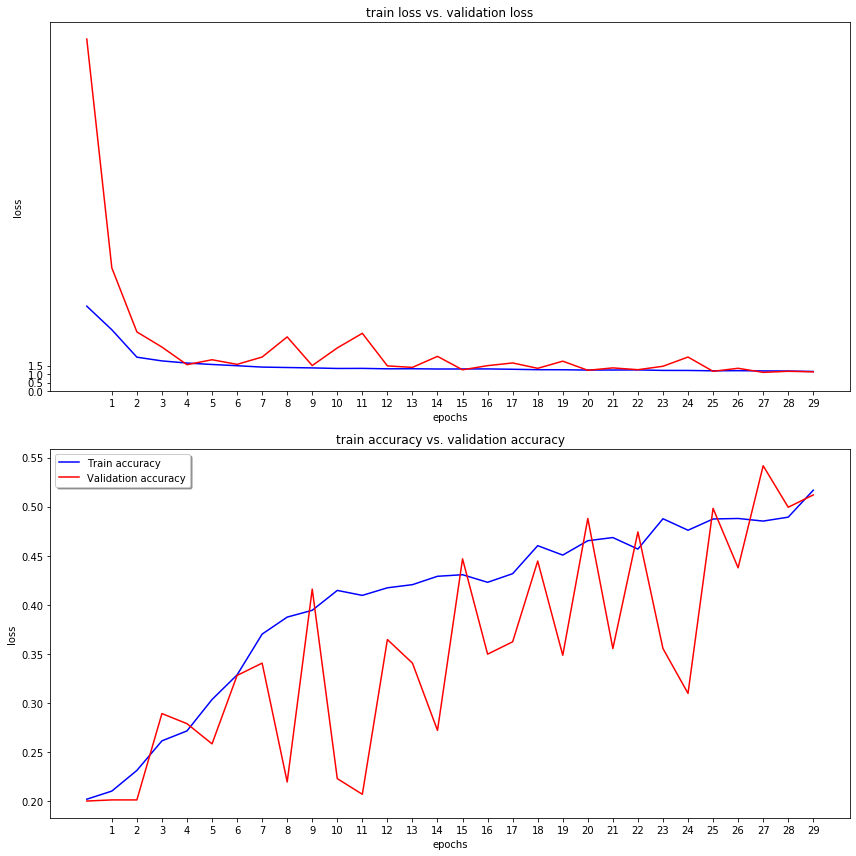

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='#ffa500', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 2, 0.5))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 2

In [12]:
# lr = 0.01
# epochs=30
# batch_sz=32
# batch_normalization reposition

print("X after normal",X_train[0][0][0])
print("y after normal",y_train[0])

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)


learn_rate = 0.01
epochs = 30
batch_size=32
opt = "sgd"

NAME = "{}-imgsz-{}-bsz-{}-lr-{}-ep".format(IMG_SIZE,
                                            batch_size,
                                            learn_rate,
                                            epochs,
                                            int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')

# def schedule(epoch):
#     if epoch < 5:
#         return .01
#     elif epoch < 25:
#         return .001
#     else:
#         return .0001
# lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
              y_train,
              batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
              epochs=20,      # epochs = how many times go through the network
              validation_data=(X_valid,y_valid),
              callbacks=[tensorboard_callback,csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/repostbatch.h5')
# print('Saved trained model at %s ' % model_path)



X after normal [0.00736686 0.00831287 0.00313475]
y after normal [0. 0. 1. 0. 0.]
X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  18:34:19
Train on 3750 samples, validate on 875 samples
Epoch 1/20
3744/3750 [============================>.] - ETA: 0s - loss: 1.7279 - accuracy: 0.2951
Epoch 00001: val_loss improved from inf to 1.87571, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.01-1.88.hdf5
3750/3750 [==============================] - 177s 47ms/sample - loss: 1.7275 - accuracy: 0.2957 - val_loss: 1.8757 - val_accuracy: 0.2000
Epoch 2/20
3744/3750 [============================>.] - ETA: 0s - loss: 1.4334 - accuracy: 0.3454
Epoch 00002: val_loss improved from 1.87571 to 1.57803, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.02-1.58.hdf5
3750/3750 

In [13]:
model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_24 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_72 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 25, 25, 256)       221440    
_________________________________________________________________
batch_normalization_25 (Batc (None, 25, 25, 256)       1024      
_________________________________________________________________
activation_73 (Activation)   (None, 25, 25, 256)      

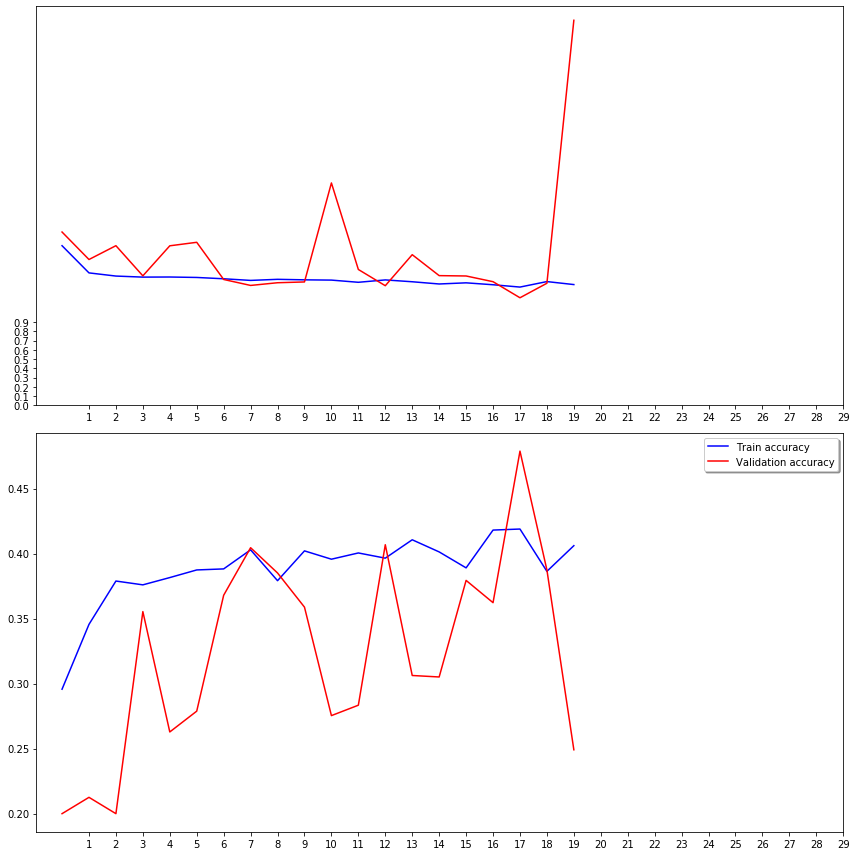

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 3

In [16]:
# learn_rate = 0.001
# epochs=30
# batch_size=32
# remove last 2 dropouts
# batchnormalization

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)


learn_rate = 0.001
epochs = 30
batch_size=32
opt = "sgd"

NAME = "{}-imgsz-{}-bsz-{}-lr-{}-ep".format(IMG_SIZE,
                                            batch_size,
                                            learn_rate,
                                            epochs,
                                            int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
#model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger(checkpoint_path+".log")


print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
              y_train,
              batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
              epochs=20,      # epochs = how many times go through the network
              validation_data=(X_valid,y_valid),
              callbacks=[tensorboard_callback,csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/iter3.h5')
# print('Saved trained model at %s ' % model_path)


X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  19:32:43
Train on 3750 samples, validate on 875 samples
Epoch 1/20
3744/3750 [============================>.] - ETA: 0s - loss: 1.6253 - accuracy: 0.3024
Epoch 00001: val_loss improved from inf to 1.97311, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.01-1.97.hdf5
3750/3750 [==============================] - 190s 51ms/sample - loss: 1.6248 - accuracy: 0.3024 - val_loss: 1.9731 - val_accuracy: 0.1486
Epoch 2/20
3744/3750 [============================>.] - ETA: 0s - loss: 1.3928 - accuracy: 0.3745
Epoch 00002: val_loss improved from 1.97311 to 1.55266, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.02-1.55.hdf5
3750/3750 [==============================] - 174s 46ms/sample - loss: 1.3927 - accuracy: 0.3

In [17]:
print("val acc:",hist.history['val_accuracy'])
print("val loss:",hist.history['val_loss'])

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print('avg acc',sum(hist.history['val_accuracy'])/epochs)
print('avg loss',sum(hist.history['val_loss'])/epochs)

val acc: [0.14857143, 0.24457143, 0.28914285, 0.328, 0.48685715, 0.27314284, 0.22628571, 0.48685715, 0.312, 0.4045714, 0.44342858, 0.352, 0.5337143, 0.48114285, 0.32685715, 0.4822857, 0.55314285, 0.5897143, 0.5165714, 0.46057144]
val loss: [1.9731149635314942, 1.5526580934524536, 1.508504450389317, 1.5589754526955741, 1.1911851058687482, 1.8277704598563058, 2.404071110861642, 1.2176764363561359, 2.5975475326265607, 1.4655020829609462, 1.338227416719709, 2.348711494445801, 1.1626102497918265, 1.3766382382256643, 1.6399082399095808, 1.5412044093268258, 1.1567833189964294, 1.0949522882189069, 1.6678890149252756, 1.5231919548852104]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_27 (Batc (None, 55, 55, 96)        384       
___________

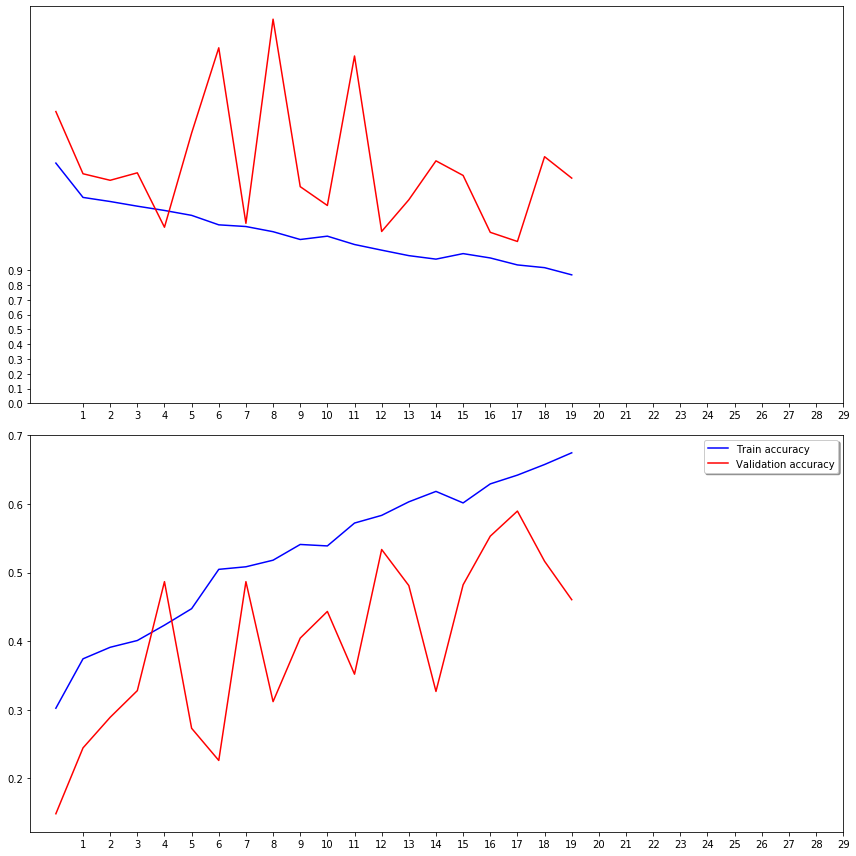

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 4

In [19]:
# learn_rate = 0.01
# epochs=30
# batch_size=32
# dropout: d5

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)


learn_rate = 0.01
epochs = 30
batch_size=32
opt = "sgd"

NAME = "{}-imgsz-{}-bsz-{}-lr-{}-ep".format(IMG_SIZE,
                                            batch_size,
                                            learn_rate,
                                            epochs,
                                            int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
#model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')


print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
              y_train,
              batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
              epochs=20,      # epochs = how many times go through the network
              validation_data=(X_valid,y_valid),
              callbacks=[tensorboard_callback,csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/iter4.h5')
# print('Saved trained model at %s ' % model_path)


X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  20:47:01
Train on 3750 samples, validate on 875 samples
Epoch 1/20
3744/3750 [============================>.] - ETA: 0s - loss: 1.6386 - accuracy: 0.2986
Epoch 00001: val_loss improved from inf to 2.71941, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.01-2.72.hdf5
3750/3750 [==============================] - 173s 46ms/sample - loss: 1.6377 - accuracy: 0.2992 - val_loss: 2.7194 - val_accuracy: 0.2000
Epoch 2/20
3744/3750 [============================>.] - ETA: 0s - loss: 1.3899 - accuracy: 0.3739
Epoch 00002: val_loss improved from 2.71941 to 1.84577, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-32-bsz-0.01-lr-30-ep.02-1.85.hdf5
3750/3750 [==============================] - 177s 47ms/sample - loss: 1.3903 - accuracy: 0.3

In [20]:
print("val acc:",hist.history['val_accuracy'])
print("val loss:",hist.history['val_loss'])

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print('avg acc',sum(hist.history['val_accuracy'])/epochs)
print('avg loss',sum(hist.history['val_loss'])/epochs)

val acc: [0.2, 0.25485715, 0.23428571, 0.24914286, 0.32457143, 0.256, 0.20571429, 0.352, 0.48114285, 0.25485715, 0.35885715, 0.3062857, 0.5462857, 0.2902857, 0.39085713, 0.33714285, 0.6331428, 0.5097143, 0.496, 0.5131429]
val loss: [2.7194095104762486, 1.8457653819492885, 1.5244916554859707, 1.8299896400996616, 1.619769989831107, 1.8637990907941546, 2.668957795551845, 1.6389931528908865, 1.2677984602791923, 2.165509093965803, 2.1567107805524555, 1.804590315410069, 1.1476967419215611, 1.9557967718669347, 1.4514883892876762, 1.9842681647709437, 0.9304175156865802, 1.387339909553528, 1.2689623462132045, 1.3845179816654751]
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_30 (Batc (None, 55, 55, 96)        384       
___________________

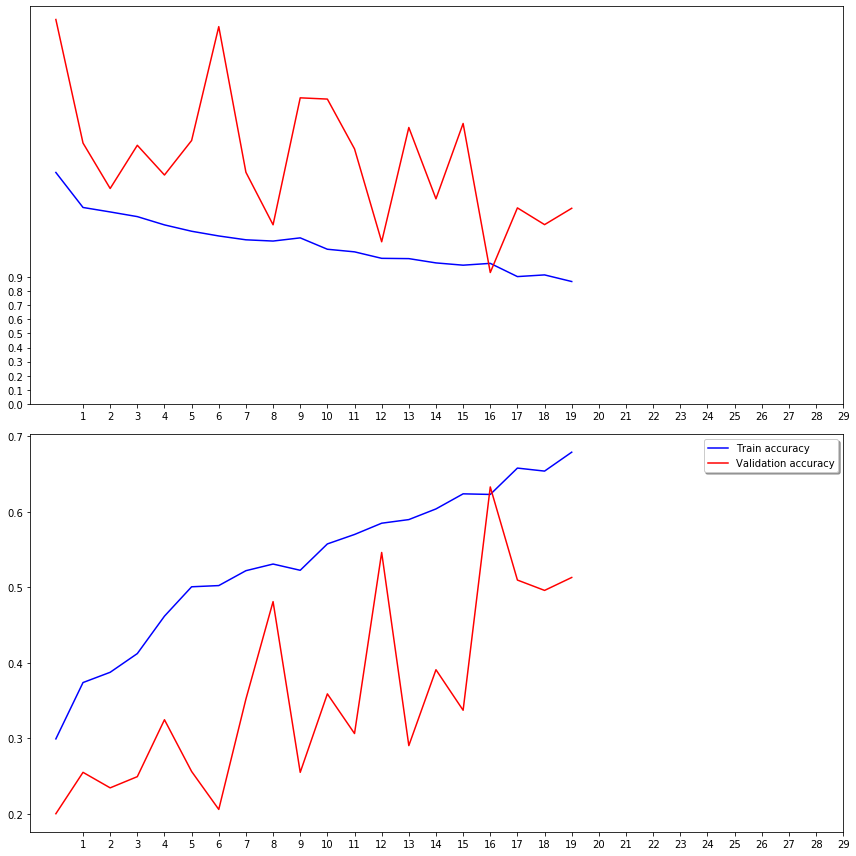

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 5

In [24]:
# learn_rate = 0.01, 0.001,0.0001
# epochs=20
# batch_size=32

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)


learn_rate = 0.01
epochs = 30
batch_size=64
opt = "sgd"

NAME = "{}-imgsz-{}-bsz-{}-lr-{}-ep".format(IMG_SIZE,
                                            batch_size,
                                            learn_rate,
                                            epochs,
                                            int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')

def schedule(epoch):
    if epoch < 5:
        return .01
    elif epoch < 25:
        return .001
    else:
        return .0001
lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
              y_train,
              batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
              epochs=20,             # epochs = how many times go through the network
              validation_data=(X_valid,y_valid),
              callbacks=[lr_scheduler,csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/iter5.h5')
# print('Saved trained model at %s ' % model_path)

X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  22:11:58
Train on 3750 samples, validate on 875 samples
Epoch 1/20
3712/3750 [============================>.] - ETA: 1s - loss: 1.8002 - accuracy: 0.2686
Epoch 00001: val_loss improved from inf to 1.71259, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-64-bsz-0.01-lr-30-ep.01-1.71.hdf5
3750/3750 [==============================] - 191s 51ms/sample - loss: 1.7977 - accuracy: 0.2688 - val_loss: 1.7126 - val_accuracy: 0.2000
Epoch 2/20
3712/3750 [============================>.] - ETA: 1s - loss: 1.4809 - accuracy: 0.3198
Epoch 00002: val_loss did not improve from 1.71259
3750/3750 [==============================] - 161s 43ms/sample - loss: 1.4798 - accuracy: 0.3189 - val_loss: 2.5375 - val_accuracy: 0.2000
Epoch 3/20
3712/3750 [============================>.] - ETA: 1s - loss: 

# summary, history

In [26]:
print("History:",hist.history)

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print('avg acc',sum(hist.history['val_accuracy'])/epochs)
print('avg loss',sum(hist.history['val_loss'])/epochs)

History: {'loss': [1.7976796585083008, 1.479809319114685, 1.407741251118978, 1.3524533227920532, 1.3450110248565674, 1.3899923262914022, 1.2880763184229533, 1.2735860014597575, 1.271330486679077, 1.2696881870905559, 1.2705107727686564, 1.2490256415049235, 1.2452337403615317, 1.2332887527465821, 1.2154850105921426, 1.2204183181126913, 1.202448764737447, 1.2058220974604288, 1.1981078628540038, 1.193836606089274], 'accuracy': [0.2688, 0.31893334, 0.36053333, 0.38613334, 0.39626667, 0.39173332, 0.43653333, 0.43626666, 0.4416, 0.44186667, 0.44373333, 0.45866665, 0.46, 0.46346667, 0.46826667, 0.46746665, 0.47706667, 0.46986666, 0.47146666, 0.48293334], 'val_loss': [1.7125881283623832, 2.5375323235648017, 2.0476775172097343, 1.6051944135938372, 1.6626626141411918, 1.6052518457685199, 1.3688144093922205, 1.3242682398387364, 1.3062339778627667, 1.2919224773134503, 1.2382504219327655, 1.2373130290167673, 1.2441010833467756, 1.3168797900336129, 1.741262479509626, 1.3710564519337245, 1.20941320078

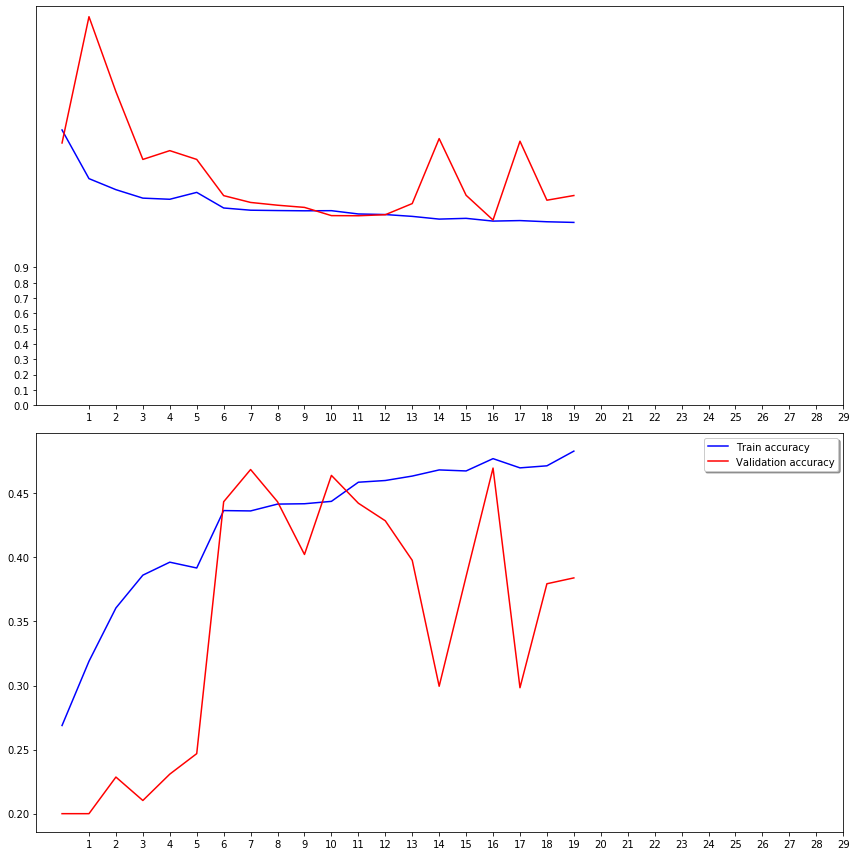

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 6

In [32]:
# learn_rate = 0.0008
# epochs=30
# batch_size=64

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)


learn_rate = 0.0008
epochs = 30
batch_size=64
opt = "sgd"

NAME = "{}-imgsz-{}-bsz-{}-lr-{}-ep".format(IMG_SIZE,
                                            batch_size,
                                            learn_rate,
                                            epochs,
                                            int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')

# def schedule(epoch):
#     if epoch < 5:
#         return .01
#     elif epoch < 25:
#         return .001
#     else:
#         return .0001
# lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
              y_train,
              batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
              epochs=epochs,      # epochs = how many times go through the network
              validation_data=(X_valid,y_valid),
              callbacks=[csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/iter6.h5')
# print('Saved trained model at %s ' % model_path)

X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  23:54:39
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.8680 - accuracy: 0.2573
Epoch 00001: val_loss improved from inf to 1.71699, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-64-bsz-0.0008-lr-30-ep.01-1.72.hdf5
3750/3750 [==============================] - 157s 42ms/sample - loss: 1.8622 - accuracy: 0.2587 - val_loss: 1.7170 - val_accuracy: 0.2000
Epoch 2/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.5857 - accuracy: 0.3540
Epoch 00002: val_loss did not improve from 1.71699
3750/3750 [==============================] - 132s 35ms/sample - loss: 1.5856 - accuracy: 0.3544 - val_loss: 2.0307 - val_accuracy: 0.2000
Epoch 3/30
3712/3750 [============================>.] - ETA: 1s - loss

Epoch 28/30
3712/3750 [============================>.] - ETA: 1s - loss: 0.6384 - accuracy: 0.7675
Epoch 00028: val_loss did not improve from 1.10426
3750/3750 [==============================] - 139s 37ms/sample - loss: 0.6381 - accuracy: 0.7675 - val_loss: 1.2284 - val_accuracy: 0.6103
Epoch 29/30
3712/3750 [============================>.] - ETA: 1s - loss: 0.6585 - accuracy: 0.7570
Epoch 00029: val_loss improved from 1.10426 to 0.83513, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-64-bsz-0.0008-lr-30-ep.29-0.84.hdf5
3750/3750 [==============================] - 131s 35ms/sample - loss: 0.6591 - accuracy: 0.7560 - val_loss: 0.8351 - val_accuracy: 0.6914
Epoch 30/30
3712/3750 [============================>.] - ETA: 1s - loss: 0.6244 - accuracy: 0.7767
Epoch 00030: val_loss did not improve from 0.83513
3750/3750 [==============================] - 136s 36ms/sample - loss: 0.6251 - accuracy: 0.7765 - val_loss: 1.1533 - val_accuracy: 0.6263
Training end  01

In [33]:
print("History:",hist.history)

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print('avg acc',sum(hist.history['val_accuracy'])/epochs)
print('avg loss',sum(hist.history['val_loss'])/epochs)

History: {'loss': [1.8621869171142578, 1.5856029699325562, 1.4276519432703654, 1.3200124003092448, 1.2768521651585898, 1.2154319168090821, 1.1726339342753092, 1.142276931508382, 1.103194376118978, 1.0632796785354615, 1.0452050156593322, 1.002593009885152, 0.9785364542007446, 0.9736673500378926, 0.9569708808898926, 0.8977741009712219, 0.8849810839970906, 0.8620304984410604, 0.8733374794324239, 0.8332143942197164, 0.8031913847287496, 0.7923353781382243, 0.7681671667098999, 0.7525906303723653, 0.7600913450241089, 0.7024279527028402, 0.6894476879755655, 0.6380608364423116, 0.6590882178624471, 0.6250965693791707], 'accuracy': [0.25866666, 0.3544, 0.40346667, 0.45573333, 0.47173333, 0.5021333, 0.5309333, 0.5432, 0.5621333, 0.58746666, 0.59653336, 0.6056, 0.6184, 0.6336, 0.6253333, 0.6533333, 0.668, 0.6672, 0.6709333, 0.6834667, 0.70533335, 0.7048, 0.71813333, 0.71466666, 0.71066666, 0.7362667, 0.74373335, 0.76746666, 0.756, 0.7765333], 'val_loss': [1.716985637664795, 2.030663464137486, 2.482

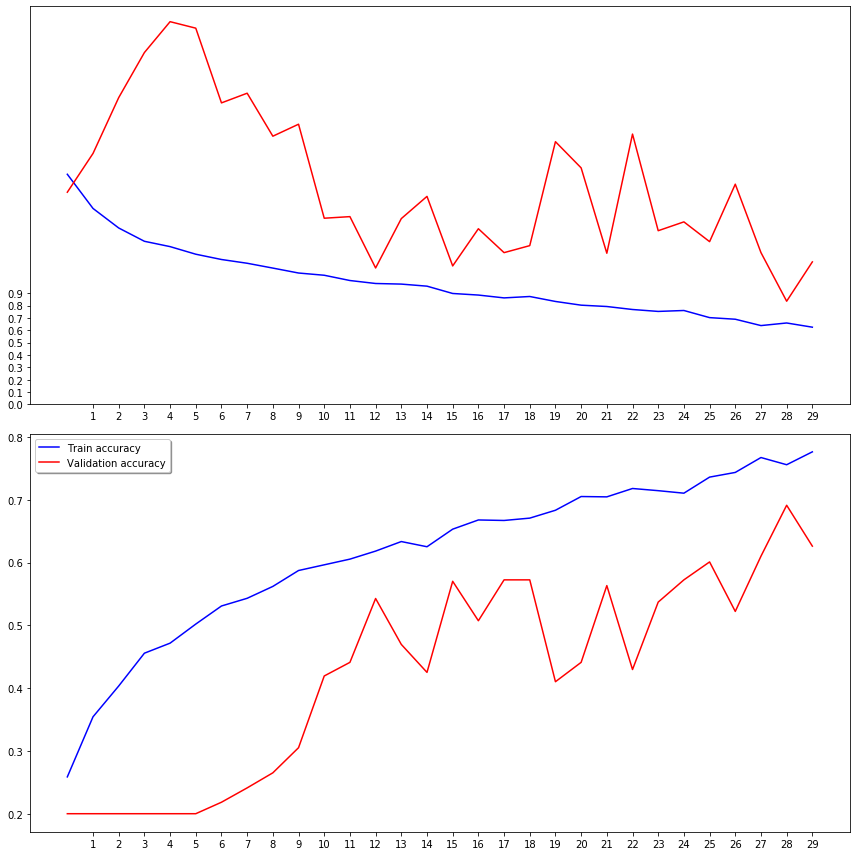

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 6

In [36]:
# learn_rate = 0.0001
# epochs=50
# batch_size=64

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)


learn_rate = 0.0001
epochs = 50
batch_size=64
opt = "sgd"

NAME = "{}-imgsz-{}-bsz-{}-lr-{}-ep".format(IMG_SIZE,
                                            batch_size,
                                            learn_rate,
                                            epochs,
                                            int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')

# def schedule(epoch):
#     if epoch < 5:
#         return .01
#     elif epoch < 25:
#         return .001
#     else:
#         return .0001
# lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
              y_train,
              batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
              epochs=epochs,      # epochs = how many times go through the network
              validation_data=(X_valid,y_valid),
              callbacks=[csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/iter7.h5')
# print('Saved trained model at %s ' % model_path)

X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  01:03:08
Train on 3750 samples, validate on 875 samples
Epoch 1/50
3712/3750 [============================>.] - ETA: 1s - loss: 1.9384 - accuracy: 0.2252
Epoch 00001: val_loss improved from inf to 1.61107, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-64-bsz-0.0001-lr-50-ep.01-1.61.hdf5
3750/3750 [==============================] - 138s 37ms/sample - loss: 1.9352 - accuracy: 0.2267 - val_loss: 1.6111 - val_accuracy: 0.2000
Epoch 2/50
3712/3750 [============================>.] - ETA: 1s - loss: 1.8342 - accuracy: 0.2637
Epoch 00002: val_loss did not improve from 1.61107
3750/3750 [==============================] - 142s 38ms/sample - loss: 1.8342 - accuracy: 0.2648 - val_loss: 1.6351 - val_accuracy: 0.2000
Epoch 3/50
3712/3750 [============================>.] - ETA: 1s - loss

Epoch 25/50
3712/3750 [============================>.] - ETA: 1s - loss: 1.0890 - accuracy: 0.5671
Epoch 00025: val_loss did not improve from 1.04218
3750/3750 [==============================] - 135s 36ms/sample - loss: 1.0878 - accuracy: 0.5677 - val_loss: 1.1036 - val_accuracy: 0.5543
Epoch 26/50
3712/3750 [============================>.] - ETA: 1s - loss: 1.0693 - accuracy: 0.5803
Epoch 00026: val_loss did not improve from 1.04218
3750/3750 [==============================] - 134s 36ms/sample - loss: 1.0681 - accuracy: 0.5805 - val_loss: 1.2544 - val_accuracy: 0.5154
Epoch 27/50
3712/3750 [============================>.] - ETA: 1s - loss: 1.0787 - accuracy: 0.5797
Epoch 00027: val_loss improved from 1.04218 to 1.02600, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/227-imgsz-64-bsz-0.0001-lr-50-ep.27-1.03.hdf5
3750/3750 [==============================] - 142s 38ms/sample - loss: 1.0791 - accuracy: 0.5800 - val_loss: 1.0260 - val_accuracy: 0.5669
Epoch 28/50
3712

In [37]:
print("History:",hist.history)

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print('avg acc',sum(hist.history['val_accuracy'])/epochs)
print('avg loss',sum(hist.history['val_loss'])/epochs)

History: {'loss': [1.9352119342168173, 1.8341693971633912, 1.7674279928207397, 1.6818427647272747, 1.6543600213368734, 1.5692781750996907, 1.505079641532898, 1.479355305926005, 1.4429289815266928, 1.409175, 1.3636102396647136, 1.3480216960271199, 1.3191932479222614, 1.289093179512024, 1.238048392613729, 1.251609146563212, 1.2597120173136394, 1.2134055852890016, 1.1887699310938518, 1.1855525879542033, 1.1484616847991944, 1.1368655534744263, 1.1233816204071045, 1.1076275436401368, 1.0877518776257833, 1.0681395129521687, 1.0791450810114542, 1.0475140206972757, 1.0456718953450521, 1.0512635529836019, 1.0164609280904133, 0.9999444489479065, 0.9836412432670594, 0.9824631319363912, 0.9435578839302063, 0.9201438358306885, 0.9474907126108806, 0.9269933513005575, 0.891481866200765, 0.8684290565172831, 0.8765065411567688, 0.8695664040247599, 0.8335437217712403, 0.8385380907694499, 0.8295431444485982, 0.795698582204183, 0.801157637055715, 0.7653139882087707, 0.7898853188832601, 0.7303862297375997]

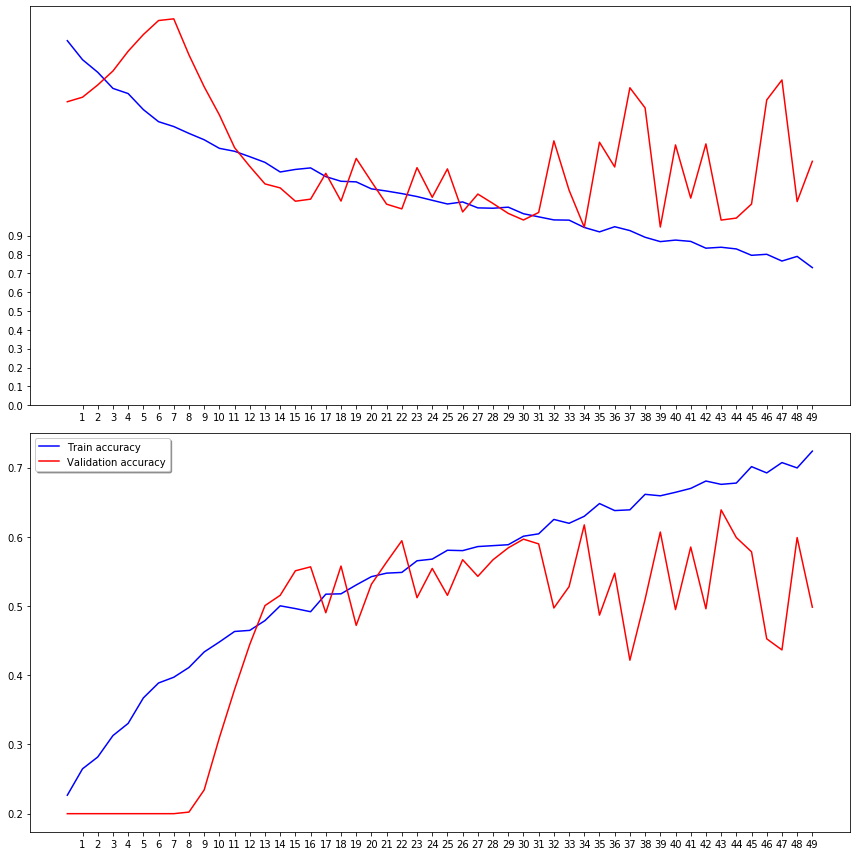

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 8

In [8]:
# learn rate sched 0.01, 0.0001
# epochs 30
# batch size 64

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)

_iter = 8
learn_rate = 0.01
epochs = 30
batch_size=64
opt = "sgd"

NAME = "()-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')

def schedule(epoch):
    if epoch < 5:
        print("0.01")
        return .01
#     elif epoch < 20:
#         return .0001
    else:
        print("0.0001")
        return .0001
lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                  y_train,
                  batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                  epochs=epochs,      # epochs = how many times go through the network
                  validation_data=(X_valid,y_valid),
                  callbacks=[lr_scheduler,csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/8.h5')
# print('Saved trained model at %s ' % model_path)

X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  09:48:12
Train on 3750 samples, validate on 875 samples
0.01
Epoch 1/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.7994 - accuracy: 0.2570
Epoch 00001: val_loss improved from inf to 1.76908, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/()-8-bsz-64-lr-0.01-ep.01-1.77.hdf5
3750/3750 [==============================] - 194s 52ms/sample - loss: 1.7976 - accuracy: 0.2565 - val_loss: 1.7691 - val_accuracy: 0.2000
0.01
Epoch 2/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.5386 - accuracy: 0.3009
Epoch 00002: val_loss did not improve from 1.76908
3750/3750 [==============================] - 158s 42ms/sample - loss: 1.5382 - accuracy: 0.3003 - val_loss: 2.2616 - val_accuracy: 0.2000
0.01
Epoch 3/30
3712/3750 [============================>.] - ETA: 1s -

3712/3750 [============================>.] - ETA: 1s - loss: 1.2922 - accuracy: 0.4270
Epoch 00025: val_loss improved from 1.31802 to 1.31710, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/()-8-bsz-64-lr-0.01-ep.25-1.32.hdf5
3750/3750 [==============================] - 176s 47ms/sample - loss: 1.2934 - accuracy: 0.4267 - val_loss: 1.3171 - val_accuracy: 0.3863
0.0001
Epoch 26/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.2919 - accuracy: 0.4256
Epoch 00026: val_loss improved from 1.31710 to 1.31675, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/()-8-bsz-64-lr-0.01-ep.26-1.32.hdf5
3750/3750 [==============================] - 177s 47ms/sample - loss: 1.2925 - accuracy: 0.4256 - val_loss: 1.3167 - val_accuracy: 0.3840
0.0001
Epoch 27/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.3039 - accuracy: 0.4291
Epoch 00027: val_loss did not improve from 1.31675
3750/3750 [==============================] - 180s 48

TypeError: can only concatenate str (not "int") to str

In [9]:
print("History:",hist.history)

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print('avg acc',sum(hist.history['val_accuracy'])/epochs)
print('avg loss',sum(hist.history['val_loss'])/epochs)

History: {'loss': [1.7976327388127644, 1.5382172782262167, 1.4547511391957602, 1.3992714942296347, 1.355936016400655, 1.5349465424219768, 1.4630758960723877, 1.422530576324463, 1.390939559427897, 1.375891703160604, 1.3666244463602701, 1.3559270938237509, 1.3398537481307984, 1.3312190088907878, 1.3273715215047202, 1.3112926036198933, 1.3214763504664102, 1.3136802929560343, 1.297599283917745, 1.3048194962819417, 1.3038065770467122, 1.3032722501118978, 1.2922216763178507, 1.2912360536575318, 1.2934178075154623, 1.2925161324183145, 1.3029660617192587, 1.293122713470459, 1.287377682050069, 1.2871025599161783], 'accuracy': [0.25653332, 0.30026665, 0.31866667, 0.36213332, 0.38213333, 0.3328, 0.34346667, 0.36373332, 0.37226668, 0.3888, 0.38506666, 0.3944, 0.39706665, 0.39413333, 0.40266666, 0.41413334, 0.40133333, 0.4048, 0.4272, 0.42346665, 0.42586666, 0.42506668, 0.42453334, 0.43386668, 0.42666668, 0.4256, 0.42906666, 0.43546668, 0.42906666, 0.42773333], 'val_loss': [1.7690802341188703, 2.26

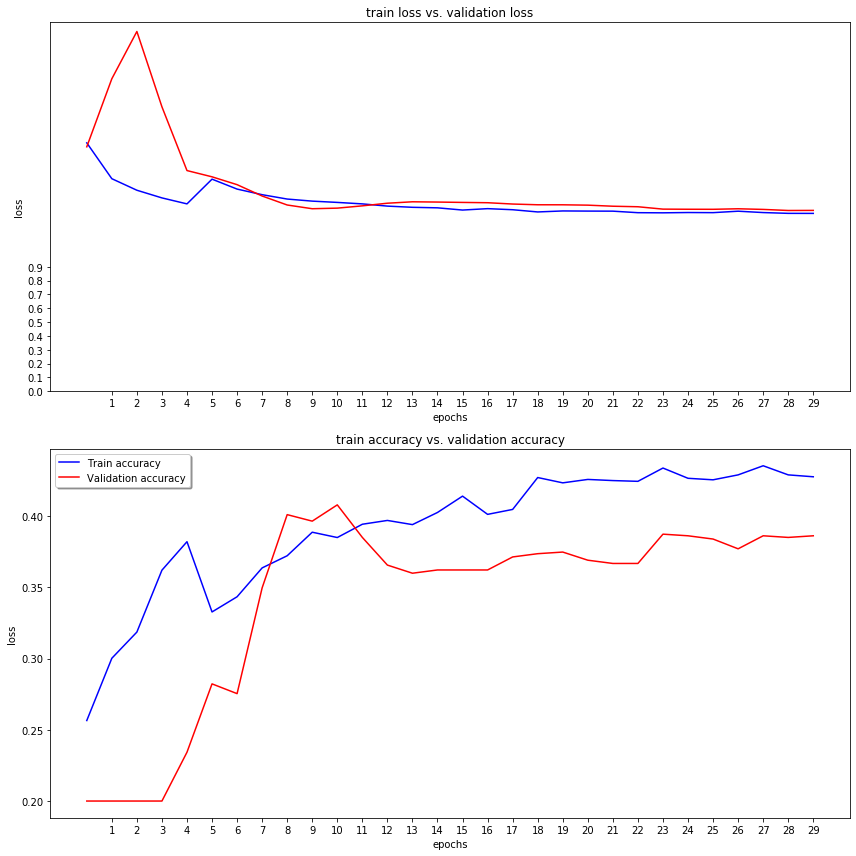

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


# Iteration 9

In [11]:
# learn rate sched 0.0001
# epochs 30
# batch size 64

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)

_iter = 9
learn_rate = 0.0001
epochs = 30
batch_size=64
opt = "sgd"

NAME = "{}-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (11,11), strides=4, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# Output layer
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')

# def schedule(epoch):
#     if epoch < 5:
#         print("0.01")
#         return .01
# #     elif epoch < 20:
# #         return .0001
#     else:
#         print("0.0001")
#         return .0001
# lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                  y_train,
                  batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                  epochs=epochs,      # epochs = how many times go through the network
                  validation_data=(X_valid,y_valid),
                  callbacks=[csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/9.h5')
# print('Saved trained model at %s ' % model_path)

X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  11:13:37
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.9649 - accuracy: 0.2163
Epoch 00001: val_loss improved from inf to 1.61703, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/9-64-bsz-0.0001-lr-30-ep.01-1.62.hdf5
3750/3750 [==============================] - 197s 53ms/sample - loss: 1.9634 - accuracy: 0.2168 - val_loss: 1.6170 - val_accuracy: 0.2000
Epoch 2/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.8419 - accuracy: 0.2589
Epoch 00002: val_loss did not improve from 1.61703
3750/3750 [==============================] - 165s 44ms/sample - loss: 1.8419 - accuracy: 0.2584 - val_loss: 1.6831 - val_accuracy: 0.2000
Epoch 3/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.7460

Epoch 26/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.0756 - accuracy: 0.5741
Epoch 00026: val_loss did not improve from 1.00617
3750/3750 [==============================] - 173s 46ms/sample - loss: 1.0762 - accuracy: 0.5744 - val_loss: 1.1838 - val_accuracy: 0.5211
Epoch 27/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.0636 - accuracy: 0.5849
Epoch 00027: val_loss did not improve from 1.00617
3750/3750 [==============================] - 177s 47ms/sample - loss: 1.0636 - accuracy: 0.5843 - val_loss: 1.0455 - val_accuracy: 0.5554
Epoch 28/30
3712/3750 [============================>.] - ETA: 1s - loss: 1.0432 - accuracy: 0.5978
Epoch 00028: val_loss did not improve from 1.00617
3750/3750 [==============================] - 165s 44ms/sample - loss: 1.0441 - accuracy: 0.5973 - val_loss: 1.2329 - val_accuracy: 0.5143
Epoch 29/30
3712/3750 [============================>.] - ETA: 1s - loss: 0.9988 - accuracy: 0.5997
Epoch 00029: val_loss did not improve

In [12]:
print("History:",hist.history)

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

History: {'loss': [1.963372755432129, 1.8418973107655843, 1.7483152480443318, 1.6887203793843588, 1.6192845416386923, 1.5605790935516357, 1.4770273825327556, 1.4499128524144491, 1.4010689641316731, 1.3893634042104086, 1.3395896664301554, 1.3251388741175334, 1.3211086709976196, 1.3049088395436605, 1.277324775568644, 1.2494031578699747, 1.2168418455759684, 1.1933827318191528, 1.1984020718256632, 1.1537827946980794, 1.1392657688776653, 1.1373301143010457, 1.1126309851964316, 1.1004343846003215, 1.084710106309255, 1.0761952509562174, 1.06355335521698, 1.0440610120137532, 1.0000152508417766, 1.0123331340471904], 'accuracy': [0.2168, 0.2584, 0.30453333, 0.31973332, 0.33813334, 0.3768, 0.4064, 0.43413332, 0.4472, 0.44533333, 0.46773332, 0.468, 0.48, 0.48266667, 0.4936, 0.49973333, 0.5192, 0.5288, 0.52453333, 0.55013335, 0.54373336, 0.55413336, 0.5616, 0.57813334, 0.584, 0.5744, 0.58426666, 0.5973333, 0.5992, 0.60373336], 'val_loss': [1.617030671937125, 1.6831118864331926, 1.8201513915743146, 

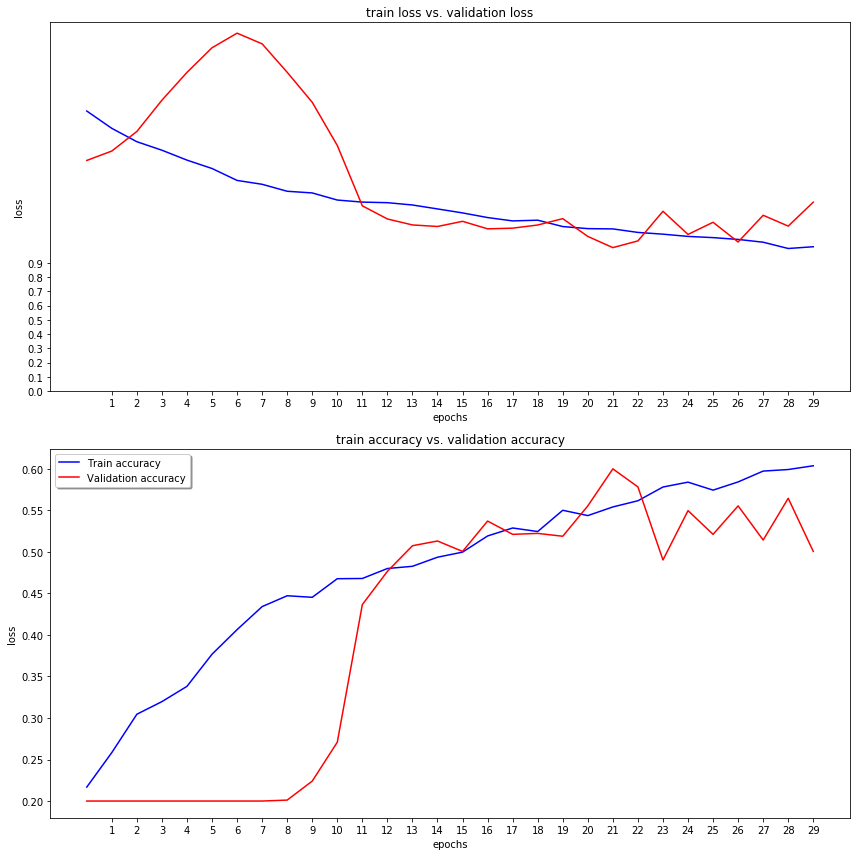

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Iteration 10

In [18]:
# change 1st convd to 7,7 str 3 
# removed d6 d8 drop outs

print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test shape", X_test.shape)
print("y_train shape", y_train.shape)
print("y_valid shape", y_valid.shape)
print("y_test shape", y_test.shape)

_iter = 10
learn_rate = 0.0005
epochs = 30
batch_size=64
opt = "sgd"

NAME = "()-{}-bsz-{}-lr-{}-ep".format(_iter,
                                        batch_size,
                                        learn_rate,
                                        epochs,
                                        int(time.time()))

log_dir="logs/" + NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)

# specify model
model = Sequential()

# layer 1: Conv1 + Relu + MaxPool
model.add(Conv2D(96, (7,7), strides=3, padding='valid',input_shape = X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 2: Conv2 + Relu + MaxPool
model.add(Conv2D(256, (3,3), strides=1, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

# layer 3: Conv3 + Relu
model.add(Conv2D(384, (5,5), strides=1, padding='valid'))
model.add(Activation('relu'))

# layer 4: Conv4 + Relu
model.add(Conv2D(384, (3,3), strides=1, padding='valid'))
model.add(Activation('relu'))

# # layer 5: Conv5 + Relu + MaxPool + Dropout
model.add(Conv2D(256, (3,3), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.50))

# # flatten before dense/fcc
model.add(Flatten())

# # layer 6: FC7 + Relu + Dropout
model.add(Dense(4096))
model.add(Activation('relu'))
#model.add(Dropout(0.50)) #bad to add drop out right before the last layer?

# layer 7: FC8 + Relu
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))

# layer 8: FC9 + Relu
model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

# Output layer
# model.add(Dense(NUM_CLASSES))
# model.add(Activation('softmax'))

# optimizer: adjust learning rates
# adam pros: low memory, works well for deep nets
#adam = tf.keras.optimizers.Adam(lr=learn_rate)
opt = optimizers.SGD(lr=learn_rate, momentum=.9)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

checkpoint_path = "/Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/"+NAME
checkpointer = ModelCheckpoint(filepath=checkpoint_path+'.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model.log')

# def schedule(epoch):
#     if epoch < 5:
#         print("0.01")
#         return .01
# #     elif epoch < 20:
# #         return .0001
#     else:
#         print("0.0001")
#         return .0001
# lr_scheduler = LearningRateScheduler(schedule)

print("Training start ",datetime.datetime.now().strftime("%H:%M:%S"))
hist = model.fit(X_train,
                  y_train,
                  batch_size=batch_size,  # batch_size is how much data a time we wanna pass through a layer
                  epochs=epochs,      # epochs = how many times go through the network
                  validation_data=(X_valid,y_valid),
                  callbacks=[csv_logger,checkpointer])
print("Training end ",datetime.datetime.now().strftime("%H:%M:%S"))


# Save model and weights

model.save_weights('/Users/flo/Desktop/456/_SEMESTER_PROJECT/saved_models/10.h5')

X_train shape (3750, 227, 227, 3)
X_valid shape (875, 227, 227, 3)
X_test shape (375, 227, 227, 3)
y_train shape (3750, 5)
y_valid shape (875, 5)
y_test shape (375, 5)
Training start  13:08:51
Train on 3750 samples, validate on 875 samples
Epoch 1/30
3712/3750 [============================>.] - ETA: 2s - loss: 1.7205 - accuracy: 0.2786
Epoch 00001: val_loss improved from inf to 1.62849, saving model to /Users/flo/Desktop/456/_SEMESTER_PROJECT/checkpoints/()-10-bsz-64-lr-0.0001-ep.01-1.63.hdf5
3750/3750 [==============================] - 293s 78ms/sample - loss: 1.7200 - accuracy: 0.2787 - val_loss: 1.6285 - val_accuracy: 0.2000
Epoch 2/30
3712/3750 [============================>.] - ETA: 2s - loss: 1.4920 - accuracy: 0.3796
Epoch 00002: val_loss did not improve from 1.62849
3750/3750 [==============================] - 281s 75ms/sample - loss: 1.4900 - accuracy: 0.3811 - val_loss: 1.7431 - val_accuracy: 0.2000
Epoch 3/30
3712/3750 [============================>.] - ETA: 2s - loss: 1.360

In [19]:
print("History:",hist.history)

model.summary()

# evaluate model on test data
scores = model.evaluate(X_test, y_test, verbose=2)
# verbose indiciator to display training progress info
# 1 (true) (default) | 0 (false)
print(NAME)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

History: {'loss': [1.7199584645589192, 1.4899738119125365, 1.3588959272384644, 1.2857186112085979, 1.2243745427449544, 1.1586310017903645, 1.1157515327453613, 1.083324657758077, 1.0165930051167806, 0.991660936164856, 0.9622779452006022, 0.9204105456670125, 0.897462426439921, 0.866474194685618, 0.841367150592804, 0.7860800051053365, 0.765248600101471, 0.7527326995531718, 0.7156285486539204, 0.7011118714014689, 0.6698208580970764, 0.6404346944491068, 0.6148409494400024, 0.5810128520170847, 0.5676945746421814, 0.5433365090370178, 0.5072191438992818, 0.48623472617467245, 0.4769574862162272, 0.43633219079971314], 'accuracy': [0.27866668, 0.38106668, 0.44826666, 0.48293334, 0.5024, 0.5402667, 0.5674667, 0.5752, 0.60693336, 0.62053335, 0.6274667, 0.6528, 0.65386665, 0.6717333, 0.6762667, 0.70533335, 0.71893334, 0.72, 0.7317333, 0.7432, 0.75226665, 0.77173334, 0.7752, 0.79866666, 0.80506665, 0.82, 0.8272, 0.83786666, 0.83573335, 0.8642667], 'val_loss': [1.6284896527699062, 1.7430860264641899, 

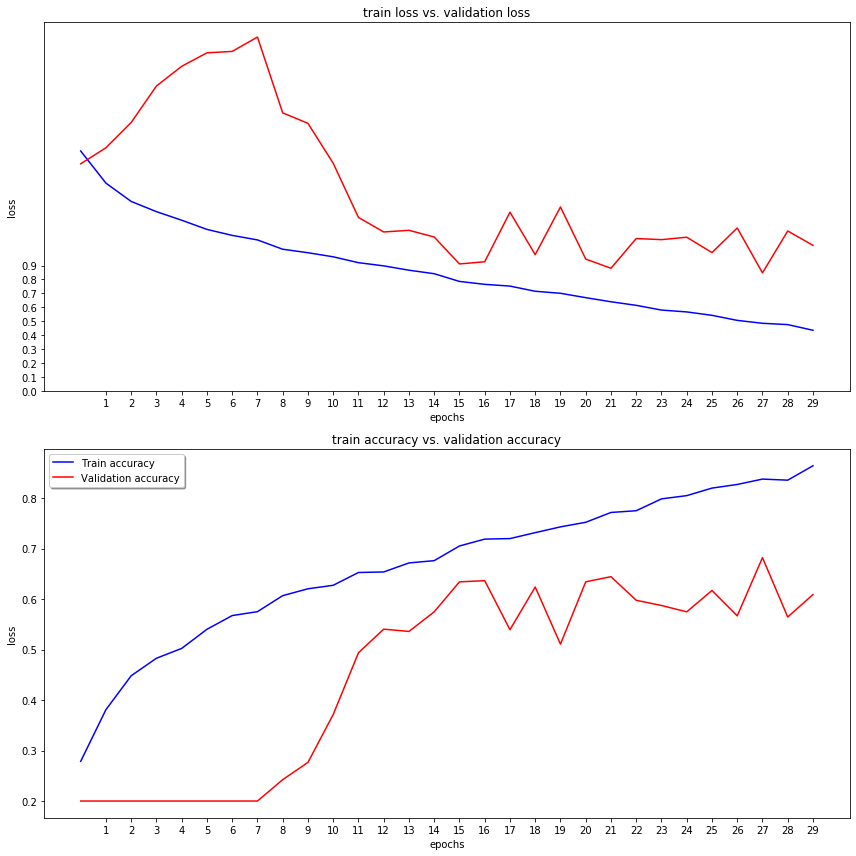

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(hist.history['loss'], color='b', label="Train loss")
ax1.plot(hist.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_ylabel('loss')
ax1.set_title('train loss vs. validation loss')
ax1.set_xlabel('epochs')

ax2.plot(hist.history['accuracy'], color='b', label="Train accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('loss')
ax2.set_title('train accuracy vs. validation accuracy')
ax2.set_xlabel('epochs')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()